In [1]:
# important Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from string import punctuation
from nltk.stem import WordNetLemmatizer

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [5]:
# check our data

In [6]:
df = pd.read_csv("C:/Users/naimu/Music/Sentiment analysis NLP & ML/All Detaset/Tripadvisor Hotel Review Sentiment Analysis/tripadvisor_hotel_reviews.csv")
df.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [7]:
#check information and show info 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [9]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [10]:
# Wordcloud


In [11]:
from wordcloud import WordCloud 
wc = WordCloud(width=800,
               height=500,
               background_color='white',
               min_font_size=10)

In [12]:
wc.generate(''.join(df['Review']))
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [13]:
# Data Visualization

In [14]:
plt.figure(figsize=(10,8))

sns.countplot(data=df,
              x='Rating',
              palette="mako",
              order = df['Rating'].value_counts().index)

plt.title('Rating Distribution')
plt.show()

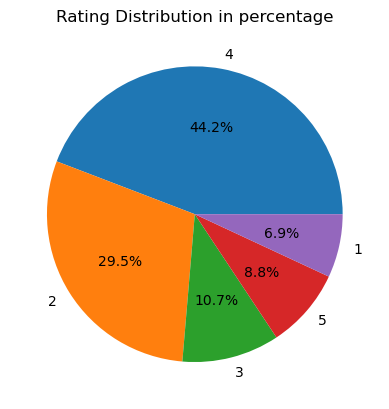

In [15]:
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.title('Rating Distribution in percentage')
plt.show()

In [16]:
# Text Preprocessing 

In [17]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [18]:
df['Rating'] = df['Rating'].apply(rating)

In [19]:
df.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...    Good
1  ok nothing special charge diamond member hilto...     Bad
2  nice rooms not 4* experience hotel monaco seat...  Netral
3  unique, great stay, wonderful time hotel monac...    Good
4  great stay great stay, went seahawk game aweso...    Good

In [20]:
# Creating a Function clean_text for text preprocessing

def clean_text(text):
    stop = stopwords.words('english')       
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return " ".join(clean_token)

In [21]:
df['Review'] = df['Review'].apply(clean_text)

In [22]:
df.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...    Good
1  ok nothing special charge diamond member hilto...     Bad
2  nice room experience hotel monaco seattle good...  Netral
3  unique great stay wonderful time hotel monaco ...    Good
4  great stay great stay went seahawk game awesom...    Good

In [23]:
# Splitting target and feature columns 


In [24]:
x = df['Review']
y = df['Rating']

In [25]:
# Train Test Split

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state=1,test_size=0.2)

In [26]:
#words in each sentence of Review column

In [27]:
sent_len = []
for sent in df['Review']:
    sent_len.append(len(word_tokenize(sent)))
df['sent_len'] = sent_len
df.head()

Review  Rating  sent_len
0  nice hotel expensive parking got good deal sta...    Good        79
1  ok nothing special charge diamond member hilto...     Bad       223
2  nice room experience hotel monaco seattle good...  Netral       183
3  unique great stay wonderful time hotel monaco ...    Good        82
4  great stay great stay went seahawk game awesom...    Good       171

In [28]:
# Checking the reveiw with max no. of words

max(sent_len)

1752

In [29]:
pd.set_option('display.max_rows', None)
print(df['sent_len'].value_counts())

48      233
45      231
47      228
54      225
50      223
46      220
44      220
39      218
43      216
36      213
37      213
52      212
32      212
57      211
38      210
60      209
30      208
42      208
40      208
56      207
61      206
58      205
34      204
35      203
53      202
55      201
67      200
31      198
49      198
63      197
41      196
51      194
29      192
33      184
69      183
65      182
66      180
59      179
62      179
68      177
64      175
25      175
70      171
73      171
71      169
75      168
28      167
26      163
27      162
79      161
76      160
77      160
83      159
24      158
78      156
74      155
72      150
82      150
81      149
92      139
88      135
91      133
23      131
89      129
20      128
85      125
80      123
94      122
21      119
86      119
22      114
97      114
84      113
87      112
90      107
93      106
18      105
98      104
105     104
96      102
103     100
95      100
100      98
104 

In [30]:
# Removing 5% of data beacuse not all sentence length is 39 which is our max sent_len.

np.quantile(sent_len,0.95)

246.0

In [31]:
max_len = 246

In [32]:
# Tokenization, Vectorization & Padding Sequence

In [33]:
# Word tokenize on basis of spacing between each words

tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(xtrain)

In [34]:
# Index of all unique tokenized words 

tok.index_word

{1: 'hotel',
 2: 'room',
 3: 'great',
 4: 'good',
 5: 'staff',
 6: 'stay',
 7: 'night',
 8: 'day',
 9: 'time',
 10: 'nice',
 11: 'location',
 12: 'stayed',
 13: 'service',
 14: 'restaurant',
 15: 'beach',
 16: 'breakfast',
 17: 'clean',
 18: 'place',
 19: 'food',
 20: 'resort',
 21: 'like',
 22: 'pool',
 23: 'really',
 24: 'bed',
 25: 'area',
 26: 'people',
 27: 'friendly',
 28: 'small',
 29: 'bar',
 30: 'walk',
 31: 'got',
 32: 'little',
 33: 'excellent',
 34: 'view',
 35: 'bathroom',
 36: 'best',
 37: 'minute',
 38: 'helpful',
 39: 'trip',
 40: 'floor',
 41: 'water',
 42: 'lot',
 43: 'recommend',
 44: 'price',
 45: 'make',
 46: 'review',
 47: 'beautiful',
 48: 'went',
 49: 'thing',
 50: 'comfortable',
 51: 'desk',
 52: 'problem',
 53: 'want',
 54: 'right',
 55: 'way',
 56: 'drink',
 57: 'city',
 58: 'free',
 59: 'wonderful',
 60: 'better',
 61: 'street',
 62: 'away',
 63: 'buffet',
 64: 'bit',
 65: 'say',
 66: 'booked',
 67: 'large',
 68: 'need',
 69: 'hour',
 70: 'quite',
 71: 'new'

In [35]:
# Total No. of Unique words inour dataset

vocab_len = len(tok.index_word)
vocab_len

38416

In [36]:
# Putting all index/unique id of each words in a sequence according to the data

sequences_train = tok.texts_to_sequences(xtrain)
sequences_train

[[483,
  2004,
  72,
  483,
  2004,
  1,
  12,
  457,
  13,
  2892,
  100,
  72,
  5,
  943,
  963,
  4696,
  289,
  12427,
  14817,
  14,
  5,
  482,
  5,
  733,
  5,
  4697,
  2893,
  374,
  13,
  887,
  21,
  453,
  2965,
  757,
  4166,
  264,
  4245,
  1912],
 [10,
  1,
  6,
  10,
  2,
  67,
  35,
  17,
  50,
  102,
  392,
  404,
  102,
  147,
  710,
  40,
  1650,
  47,
  40,
  9027,
  5,
  103,
  2,
  40,
  9027,
  204,
  31,
  187,
  5,
  38,
  21,
  358,
  1,
  5,
  836,
  19449,
  1725,
  2028,
  307,
  6698,
  426,
  3544,
  31,
  148,
  587,
  887,
  2134,
  19450,
  7915,
  59,
  19,
  214,
  99,
  1096,
  14,
  7,
  1005,
  117,
  1304,
  1705,
  1,
  922,
  7,
  132,
  25,
  601,
  6699,
  189,
  7033,
  14,
  34,
  1096,
  804,
  43,
  3,
  14818,
  8,
  39,
  3797,
  9028,
  5763,
  5058,
  145,
  135,
  340,
  1,
  6],
 [572,
  20,
  175,
  74,
  572,
  840,
  20,
  1,
  1507,
  47,
  837,
  15,
  688,
  1464,
  99,
  1813,
  3038,
  8,
  8,
  678,
  505,
  2005,
  1781

In [37]:
# Padding Sequence

sequence_matrix_train = sequence.pad_sequences(sequences_train,maxlen=max_len)
sequence_matrix_train

array([[    0,     0,     0, ...,   264,  4245,  1912],
       [    0,     0,     0, ...,   340,     1,     6],
       [    0,     0,     0, ...,     4,  1795,   588],
       ...,
       [    0,     0,     0, ...,     2, 38416,   268],
       [    0,     0,     0, ...,  1087,    43,     1],
       [    0,     0,     0, ...,  2819,  6535,   105]])

In [38]:
# One hot encoding the label
lb = LabelEncoder()
ytrain = lb.fit_transform(ytrain)
ytest = lb.transform(ytest)

In [39]:
# (Neural Network)

In [45]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras import regularizers

vocab_len = 38416
max_len = 1752

model = Sequential()  
model.add(Embedding(vocab_len + 1, 500, mask_zero=True))  # Embedding
model.add(LSTM(16, activation='tanh'))  # LSTM Layer
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # Hidden Layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Output Layer


In [51]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras import regularizers

vocab_len = 38416
max_len = 1752

model = Sequential()  
model.add(Embedding(vocab_len + 1, 500, mask_zero=True))  # Embedding
model.add(LSTM(16, activation='tanh'))  # LSTM Layer
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # Hidden Layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Output Layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Once trained, you can print the summary
model.summary()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3167 - loss: 3.3912
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2979 - loss: 3.5884
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2679 - loss: 5.5771
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2684 - loss: 6.7841
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3166 - loss: 8.1578
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2935 - loss: 9.4370
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2961 - loss: 10.9841
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2990 - loss: 13.3245
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2813 - loss: 13.7682
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3150 - loss: 16.9843


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 1752, 500)           │      19,208,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │          33,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,725,255 (220.20 MB)

 Trainable params: 19,241,751 (73.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,483,504 (146.80 MB)

In [52]:
# Compile our Model

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Training our model

trained_model = model.fit(sequence_matrix_train,ytrain,epochs=20)

Epoch 1/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 172s 322ms/step - accuracy: 0.4867 - loss: 1.7776
Epoch 2/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 169s 329ms/step - accuracy: 0.6513 - loss: 0.8827
Epoch 3/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 168s 328ms/step - accuracy: 0.6922 - loss: 0.7668
Epoch 4/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 171s 333ms/step - accuracy: 0.7211 - loss: 0.6903
Epoch 5/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 166s 323ms/step - accuracy: 0.7364 - loss: 0.5989
Epoch 6/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 164s 319ms/step - accuracy: 0.7329 - loss: 0.5354
Epoch 7/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 168s 327ms/step - accuracy: 0.7390 - loss: 0.4750
Epoch 8/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 170s 332ms/step - accuracy: 0.7288 - loss: 0.4498
Epoch 9/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 170s 331ms/step - accuracy: 0.8128 - loss: 0.4063
Epoch 10/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 162s 316ms/step - accuracy: 0.8527 - loss: 0.3856
Epoch 11/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 162s 316ms/step - accuracy: 0.8581 - loss: 0.3731
Epoch 12

In [54]:
# Giving each unique tokens/word a unique Id or index and the apply padding sequence

sequence_matrix_test = sequence.pad_sequences(tok.texts_to_sequences(xtest),maxlen=max_len)

In [55]:
# Checking Training and Testing loss 

print('Training_loss :',model.evaluate(sequence_matrix_train,ytrain))
print('Testing_loss :',model.evaluate(sequence_matrix_test,ytest))

513/513 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.8875 - loss: 0.2726
Training_loss : [0.2715798318386078, 0.8866520524024963]
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.7864 - loss: 1.0677
Testing_loss : [1.0655986070632935, 0.7816540598869324]


In [56]:
# Testing our model

Y_pred = model.predict(sequence_matrix_test)
print(np.round(Y_pred,3))

129/129 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step
[[0.    1.    0.   ]
 [0.046 0.858 0.097]
 [0.    1.    0.   ]
 ...
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [0.324 0.337 0.34 ]]


In [57]:
# List comprehension to select class with highest probability

Y_pred = [np.argmax(i) for i in Y_pred]
Y_pred

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,


In [58]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(ytest,Y_pred))
print(confusion_matrix(ytest,Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.64      0.56       649
           1       0.86      0.92      0.89      3042
           2       0.26      0.01      0.02       408

    accuracy                           0.78      4099
   macro avg       0.54      0.52      0.49      4099
weighted avg       0.74      0.78      0.75      4099

[[ 413  230    6]
 [ 248 2786    8]
 [ 175  228    5]]


In [59]:
# Prediction

In [60]:
def dl_predict(text):
    cleantext = clean_text(text)
    seq = tok.texts_to_sequences([cleantext])
    padded = sequence.pad_sequences(seq)

    pred = model.predict(padded)
    # Get the index of the maximum value in the prediction array
    predicted_index = np.argmax(pred, axis=1)[0]
    # Get the label name using the index
    result = lb.classes_[predicted_index]

    return result

In [61]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Prediction using DNN: Good


In [62]:
text3 = 'Had a bad experience but scenery was good'

print('Prediction using DNN: {}'.format(dl_predict(text3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction using DNN: Bad
